In [2]:
from FedAvg_models import *
from utils import *

In [3]:
## uncomment for colab
## upload datasetGenerator.py for preprocessing dataset

# from google.colab import drive
# drive.mount('/content/drive')
# ! unzip -q "/content/drive/MyDrive/Colab Notebooks/BVP.zip"
# ! python /content/datasetGenerator.py

Mounted at /content/drive
client 1 data extraction:

Loaded dataset of 3525 samples, each sized (38, 20, 20)

client 2 data extraction:

Loaded dataset of 3248 samples, each sized (38, 20, 20)

client 3 data extraction:

Loaded dataset of 2500 samples, each sized (38, 20, 20)

client 4 data extraction:

Loaded dataset of 375 samples, each sized (38, 20, 20)

client 5 data extraction:

Loaded dataset of 500 samples, each sized (38, 20, 20)

client 6 data extraction:

Loaded dataset of 624 samples, each sized (38, 20, 20)

client 7 data extraction:

Loaded dataset of 374 samples, each sized (38, 20, 20)

client 8 data extraction:

Loaded dataset of 374 samples, each sized (38, 20, 20)

client 9 data extraction:

Loaded dataset of 375 samples, each sized (38, 20, 20)

client 10 data extraction:

Loaded dataset of 375 samples, each sized (38, 20, 20)

client 11 data extraction:

Loaded dataset of 375 samples, each sized (38, 20, 20)

client 12 data extraction:

Loaded dataset of 375 sample

In [3]:
fraction_for_test = 0.15
num_class = 4
ALL_MOTION = [i for i in range(1, num_class+1)]
N_MOTION = len(ALL_MOTION) # Number of output classes
T_MAX = 38 # Number of timestamps
n_gru_hidden_units = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

destination_folder = './results'
try:
    os.makedirs(destination_folder)
except:
    pass

# Model

In [6]:
class CNNModule(nn.Module):
    def __init__(self):
        super(CNNModule, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=2, padding='same'),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(8 * 10 * 10, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, 32),
            nn.ReLU()
        )

    def forward(self, x):
        return self.cnn(x)

class ConvGRUModel(nn.Module):
    def __init__(self, hidden_size, num_classes, num_timestamps):
        super(ConvGRUModel, self).__init__()

        # CNN module for each input timestamp
        self.cnn_modules = nn.ModuleList([
            CNNModule() for _ in range(num_timestamps)
        ])

        # GRU layers
        self.gru = nn.GRU(32, hidden_size, num_layers=num_timestamps, batch_first=True, dropout=0.25)

        # Fully connected layer at the output of last GRU
        self.fc_out = nn.Linear(hidden_size, num_classes)

        # Relu activation for fully connected
        self.relu = nn.ReLU()
        # Softmax activation for classification
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Apply CNN module sequentially for each timestamp
        x = x.unsqueeze(2)
        x = np.swapaxes(x, 0, 1)
        x = [module(xi) for module, xi in zip(self.cnn_modules, x)]
        x = torch.stack(x, dim=1)  # Stack along the time dimension

        # GRU layer
        x, _ = self.gru(x)

        # Apply ReLU activation after the GRU layer
        x = self.relu(x)

        # Fully connected layer at the output of last GRU
        x = self.fc_out(x[:, -1, :])

        # Softmax for classification
        x = self.softmax(x)

        return x

## Load dataset

In [4]:
# Load datasets
num_clients = 5
batch_size = 32
client_datasets = {}
client_loaders = {}

for i in range(1, num_clients + 1):
    # Load client data
    client_data = torch.load(f'./data/data{i}.pt')
    data = torch.from_numpy(client_data['data']).float()
    label = torch.from_numpy(client_data['label']).long()

    # Split data into training and testing sets
    data_train, data_test, label_train, label_test = train_test_split(
        data, label, test_size=fraction_for_test, random_state=66
    )

    train_dataset = TensorDataset(data_train, label_train)
    test_dataset = TensorDataset(data_test, label_test)
    client_datasets[f'client{i}'] = {'train': train_dataset, 'test':test_dataset}

    # Set up data loaders for each client's
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    client_loaders[f'client{i}'] = {'train': train_loader, 'test':test_loader}

## FedAvg

In [7]:
fed_avg_algorithm = FedAvgAlgorithm(model=ConvGRUModel,
                                    n_gru_hidden_units=n_gru_hidden_units,
                                    num_class=N_MOTION,
                                    timestamp=T_MAX,
                                    train_loader=client_loaders
                                    )

fed_avg_round_accuracy, fed_avg_result = fed_avg_algorithm.run(num_rounds=10,
                                                               num_epochs=4
                                                               )

# Save to a file using pickle
with open('./results/fed_avg_result.pkl', 'wb') as file:
    pickle.dump(fed_avg_result, file)

with open('./results/fed_avg_round_accuracy.pkl', 'wb') as file:
    pickle.dump(fed_avg_round_accuracy, file)


---------- Round 1/10 ----------

Training on Client 1
        Epoch: 1, Train Loss: 1.3934, Train Accuracy: 24.93%,  Val Loss: 1.4155, Val Accuracy: 24.76%
        Epoch: 2, Train Loss: 1.3932, Train Accuracy: 25.93%,  Val Loss: 1.3953, Val Accuracy: 22.12%
        Epoch: 3, Train Loss: 1.3898, Train Accuracy: 26.00%,  Val Loss: 1.3902, Val Accuracy: 24.76%
        Epoch: 4, Train Loss: 1.3891, Train Accuracy: 25.73%,  Val Loss: 1.3854, Val Accuracy: 24.76%

Training on Client 2
        Epoch: 1, Train Loss: 1.3764, Train Accuracy: 32.57%,  Val Loss: 1.3551, Val Accuracy: 38.93%
        Epoch: 2, Train Loss: 1.3771, Train Accuracy: 33.15%,  Val Loss: 1.3387, Val Accuracy: 38.93%
        Epoch: 3, Train Loss: 1.3702, Train Accuracy: 33.88%,  Val Loss: 1.3380, Val Accuracy: 38.93%
        Epoch: 4, Train Loss: 1.3726, Train Accuracy: 33.88%,  Val Loss: 1.3480, Val Accuracy: 38.93%

Training on Client 3
        Epoch: 1, Train Loss: 1.3650, Train Accuracy: 32.00%,  Val Loss: 1.3518, Val

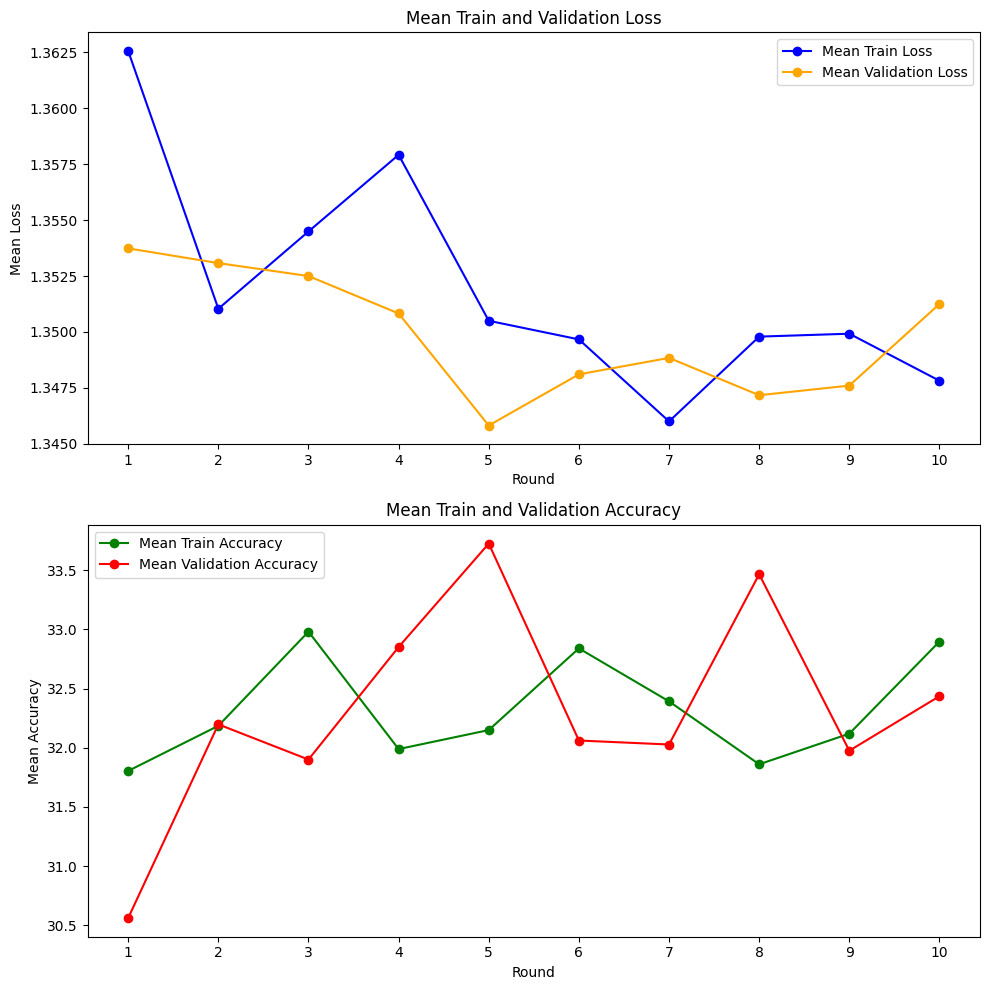

In [8]:
with open('./results/fed_avg_result.pkl', 'rb') as file:
    fed_avg_result = pickle.load(file, encoding='latin1')

plot_result(fed_avg_result)

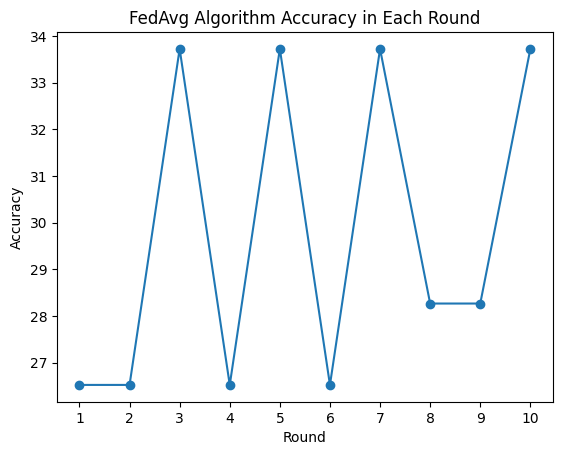

In [9]:
rounds = range(1, len(fed_avg_round_accuracy) + 1)

# Plot the accuracy values
plt.plot(rounds, fed_avg_round_accuracy, marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('FedAvg Algorithm Accuracy in Each Round')
plt.xticks(rounds)

# Display the plot
plt.show()

# Model robustness

## Sharpness Aware Minimization

In [10]:
fed_avg_algorithm = FedAvgAlgorithm_SAM(model=ConvGRUModel,
                                    n_gru_hidden_units=n_gru_hidden_units,
                                    num_class=N_MOTION,
                                    timestamp=T_MAX,
                                    train_loader=client_loaders
                                    )

fed_avg_SAM_round_accuracy, fed_avg_SAM_result = fed_avg_algorithm.run(num_rounds=10,
                                                               num_epochs=4
                                                               )

# Save to a file using pickle
with open('./results/fed_avg_SAM_result.pkl', 'wb') as file:
    pickle.dump(fed_avg_SAM_result, file)

with open('./results/fed_avg_SAM_round_accuracy.pkl', 'wb') as file:
    pickle.dump(fed_avg_SAM_round_accuracy, file)


---------- Round 1/10 ----------

Training on Client 1
        Epoch: 1, Train Loss: 1.3859, Train Accuracy: 26.47%,  Val Loss: 1.3856, Val Accuracy: 24.76%
        Epoch: 2, Train Loss: 1.3852, Train Accuracy: 26.50%,  Val Loss: 1.3856, Val Accuracy: 24.76%
        Epoch: 3, Train Loss: 1.3853, Train Accuracy: 26.50%,  Val Loss: 1.3854, Val Accuracy: 24.76%
        Epoch: 4, Train Loss: 1.3851, Train Accuracy: 26.27%,  Val Loss: 1.3855, Val Accuracy: 24.76%

Training on Client 2
        Epoch: 1, Train Loss: 1.3693, Train Accuracy: 33.88%,  Val Loss: 1.3403, Val Accuracy: 38.93%
        Epoch: 2, Train Loss: 1.3670, Train Accuracy: 33.88%,  Val Loss: 1.3409, Val Accuracy: 38.93%
        Epoch: 3, Train Loss: 1.3666, Train Accuracy: 33.88%,  Val Loss: 1.3395, Val Accuracy: 38.93%
        Epoch: 4, Train Loss: 1.3653, Train Accuracy: 33.88%,  Val Loss: 1.3379, Val Accuracy: 38.93%

Training on Client 3
        Epoch: 1, Train Loss: 1.3597, Train Accuracy: 34.73%,  Val Loss: 1.3467, Val

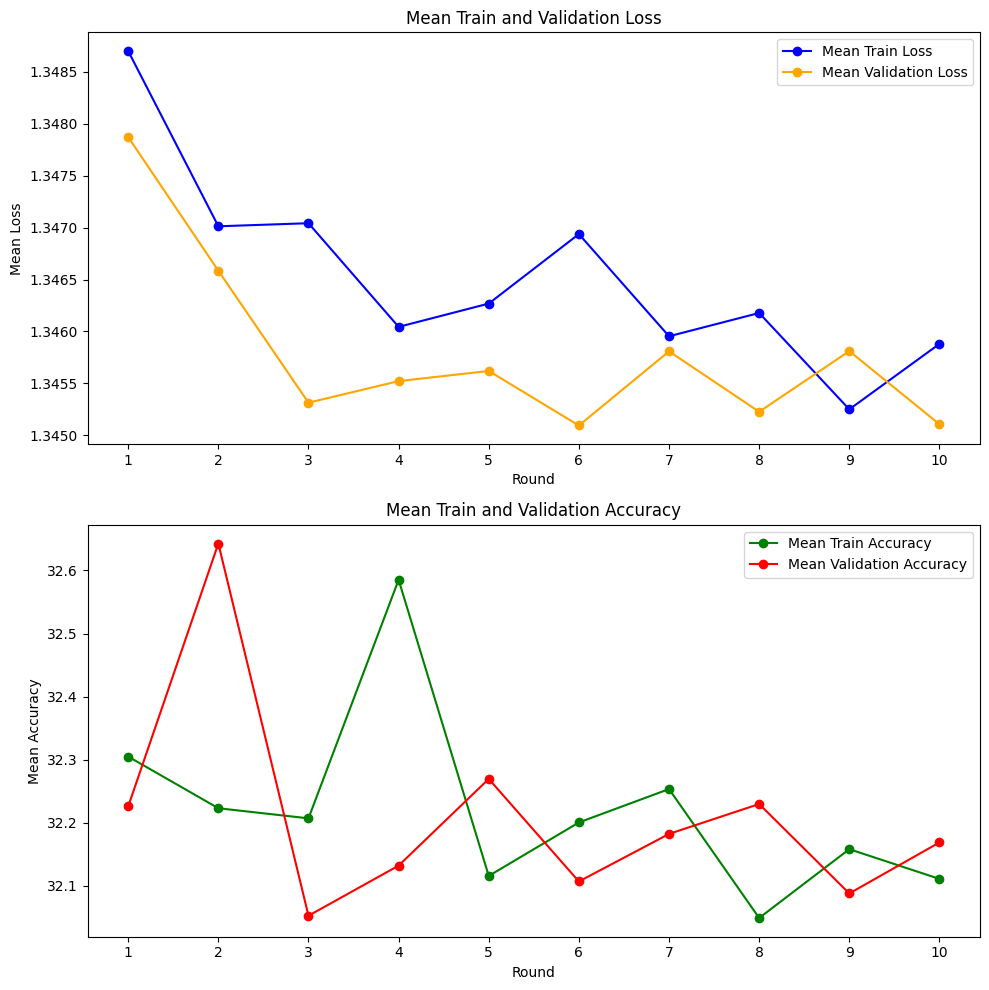

In [11]:
plot_result(fed_avg_SAM_result)

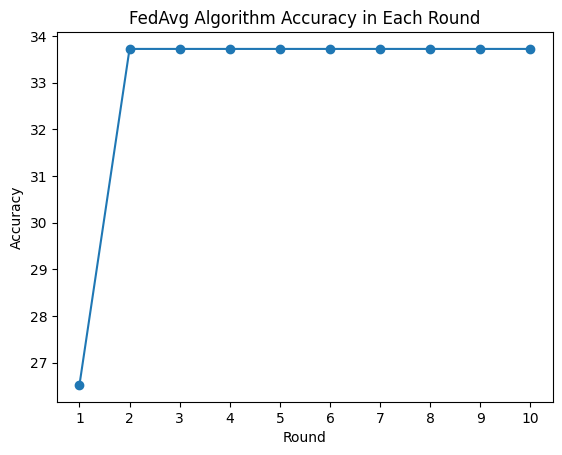

In [12]:
rounds = range(1, len(fed_avg_SAM_round_accuracy) + 1)

# Plot the accuracy values
plt.plot(rounds, fed_avg_SAM_round_accuracy, marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('FedAvg Algorithm Accuracy in Each Round')
plt.xticks(rounds)

# Display the plot
plt.show()

## FGSM

In [13]:
fed_avg_algorithm = FedAvgAlgorithm_FGSM(model=ConvGRUModel,
                                        n_gru_hidden_units=n_gru_hidden_units,
                                        num_class=N_MOTION,
                                        timestamp=T_MAX,
                                        train_loader=client_loaders
                                        )

fed_avg_FGSM_round_accuracy, fed_avg_FGSM_result = fed_avg_algorithm.run(num_rounds=10,
                                                                        num_epochs=4
                                                                        )

# Save to a file using pickle
with open('./results/fed_avg_FGSM_result.pkl', 'wb') as file:
    pickle.dump(fed_avg_FGSM_result, file)

with open('./results/fed_avg_FGSM_round_accuracy.pkl', 'wb') as file:
    pickle.dump(fed_avg_FGSM_round_accuracy, file)


---------- Round 1/10 ----------

Training on Client 1
        Epoch: 1, Train Loss: 2.8129, Train Accuracy: 25.77%,  Val Loss: 1.4236, Val Accuracy: 24.76%
        Epoch: 2, Train Loss: 2.8211, Train Accuracy: 26.47%,  Val Loss: 1.4529, Val Accuracy: 25.90%
        Epoch: 3, Train Loss: 2.8725, Train Accuracy: 26.47%,  Val Loss: 1.4384, Val Accuracy: 24.76%
        Epoch: 4, Train Loss: 2.8104, Train Accuracy: 26.37%,  Val Loss: 1.3976, Val Accuracy: 22.12%

Training on Client 2
        Epoch: 1, Train Loss: 2.7549, Train Accuracy: 32.68%,  Val Loss: 1.3392, Val Accuracy: 38.93%
        Epoch: 2, Train Loss: 2.7618, Train Accuracy: 32.10%,  Val Loss: 1.3663, Val Accuracy: 38.93%
        Epoch: 3, Train Loss: 2.7554, Train Accuracy: 32.46%,  Val Loss: 1.3488, Val Accuracy: 38.93%
        Epoch: 4, Train Loss: 2.7568, Train Accuracy: 33.37%,  Val Loss: 1.3386, Val Accuracy: 38.93%

Training on Client 3
        Epoch: 1, Train Loss: 2.7326, Train Accuracy: 33.55%,  Val Loss: 1.3560, Val

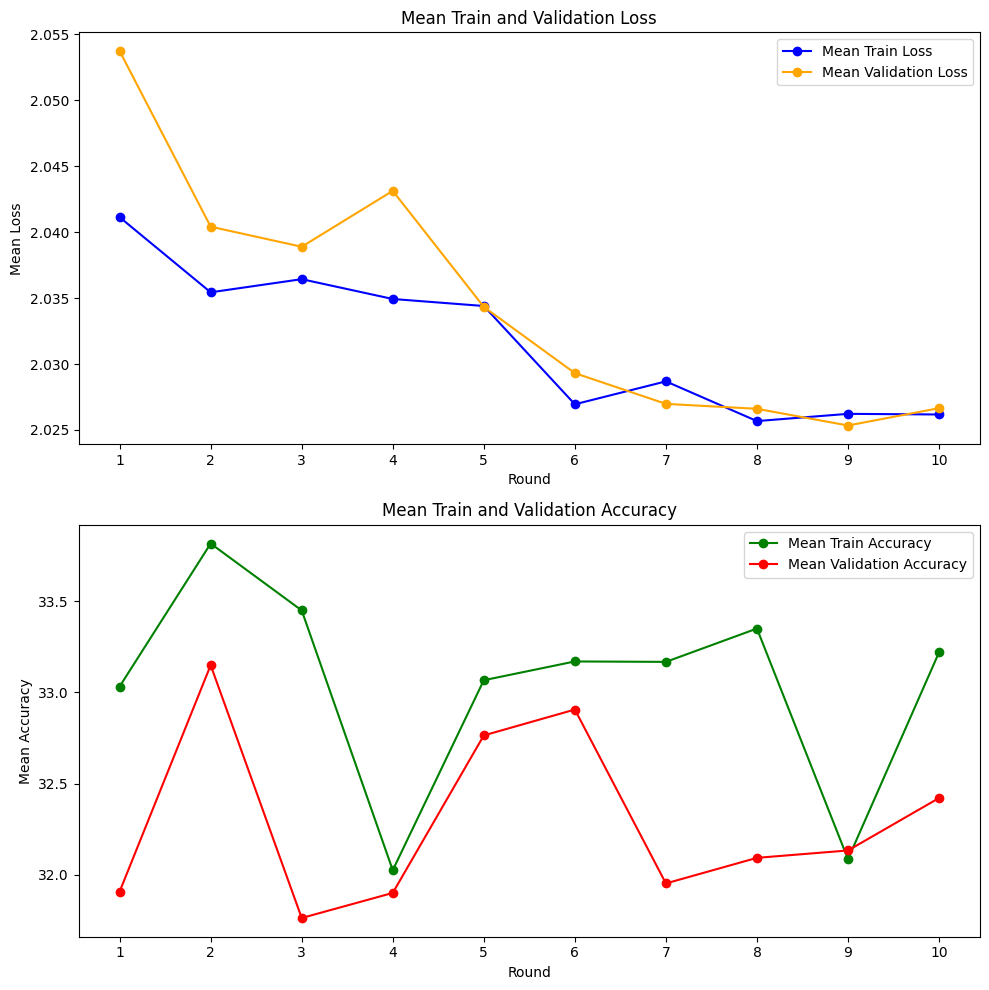

In [16]:
plot_result(fed_avg_FGSM_result)

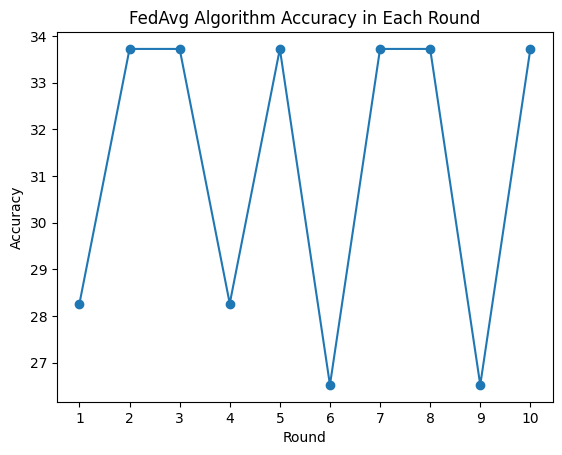

In [15]:
rounds = range(1, len(fed_avg_FGSM_round_accuracy) + 1)

# Plot the accuracy values
plt.plot(rounds, fed_avg_FGSM_round_accuracy, marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('FedAvg Algorithm Accuracy in Each Round')
plt.xticks(rounds)

# Display the plot
plt.show()

# Attack

In [12]:
def evasion_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def attack_test(model, device, test_loader, epsilon= 0.1):

    correct = 0
    total = 0
    for data, labels in test_loader:
        model.eval()
        data, labels = data.to(device), labels.to(device)
        data.requires_grad = True
        outputs = model(data)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_images = evasion_attack(data, epsilon, data_grad)
        outputs = model(perturbed_images)
        _, predicted = outputs.max(1)
        # Count correct predictions
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test data after evasion attack: {accuracy:.2f}%')


In [14]:
model = ConvGRUModel(n_gru_hidden_units, N_MOTION, T_MAX)
model.load_state_dict(torch.load('./results/FedAvg/FedAvg_model.pth'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

attack_test(model, device, client_loaders['client1']['test'])

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same